### TMA4320 - Project 2: Physics


# 0.0 Motivation

In [1]:

# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from tempfile import TemporaryFile


# To show figures in the notebook
%matplotlib inline

# Make the figures more readable
newparams = {'figure.figsize': (18, 9), 'axes.grid': False,
             'lines.linewidth': 2,
             'font.size': 25, 'mathtext.fontset': 'stix',
             'font.family': 'STIXGeneral'}
# figure.figsize sets the size of the figure (values are in inches)
# axes.grid, set to False means that there is no grid
# lines.linewidth sets the thickness of the lines in the plot
# font.size sets the size of the text (ticks, title, xlabel, etc.)
# mathtext.fontset sets the font of the text of the type r'$tekst$' (math text)
# font.family sets the font of ordinary text (ticks, title, xlabel, etc.)

# There are several other parameters you can change, and you can look them up in the documentation 
# for matplotlib if you need to change any. 

plt.rcParams.update(newparams) # Updates the parameter set above. 

In [2]:
# Parameters
sigma_0 = 1000 # kg/m^2
sigma = 500 # kg/m^2
R = 10 # m, Radius
A_s = 0.5*np.pi*(R**2) # Cross-section of boat
g = 9.81 # m/s^2
h = (4*R)/(3*np.pi)
m_boat = A_s*sigma

A_0 = (sigma*np.pi*(R**2))/(2*sigma_0)


For å undersøke båtens endring i hellingsvinkel

In [3]:
def calculate_I_c(m_load, s_L):
    '''
    This function calculated the ships total rotational inertia of the ship and its load, at the
    relative position of the load affects the total rotational inertia.
    Input:
        m_load: float, the mass of the load [kg]
        s_L:    float, the loads distance from the metacenter [m]
    Output:
        I_c:    float, the ships total rotational inertia [kg/m²]
    '''
    I_boat = 0.5*m_boat*(R**2)*(1-(32/(9*(np.pi**2)))) # Rotational inertia from the ship about C

    r_load = np.sqrt( h**2 + s_L**2 ) # Distance from ship's CM to load's CM
    I_load = m_load*r_load**2   # Rotational inertia from the load about C 
    
    I_c = I_load + I_boat # Use the superposition property of rotational inertias (Steiner's Thm).
    return I_c


# print(calculate_I_c(0.001*m_boat, 0))
# print(calculate_I_c(0.001*m_boat, R))

In [4]:
def calculate_beta(rhs_constant, x0, tol=1.e-8, max_iter=50):
    ''' Given a right hand side and left hand side of a function and its derivatives, calculates the beta value of the function.
    
    Solve f(x)=0 by Newtons method, 
    
        The output of each iteration is printed
        Input:
        f_lhs: left hand side of function
        df_lhs: left hand side of derivative of function
        f_rhs: right hand side of function
        df_rhs: right hand side of derivative of function
        x0:  Initial values
        tol: The tolerance
      Output:
        The root and the number of iterations
    '''

    f = lambda beta: beta - np.sin(beta) - rhs_constant
    df = lambda beta: 1 - np.cos(beta)


    x = x0
    for k in range(max_iter):
        fx = f(x)
        if abs(fx) < tol:           # Accept the solution 
            break 
        x = x - fx/df(x)            # Newton-iteration
    return x

In [5]:
def print_beta():
    f_lhs = lambda beta: beta-np.sin(beta)
    df_lhs = lambda beta: 1 - np.cos(beta)

    f_rhs = lambda beta : np.pi * sigma/sigma_0
    df_rhs = 0

    beta = calculate_beta(np.pi*sigma/sigma_0,5)
    print("Beta = ",round(np.degrees(beta), 2),"degrees")
print_beta()

Beta =  132.35 degrees


In [6]:
#Define the global variables for the equilibrium, as requested in 1b)
y_M_0 = lambda beta: R*np.cos(beta/2)
y_C_0 = lambda beta: y_M_0(beta) - 4*R/(3*np.pi)
y_B_0 = lambda beta: y_M_0(beta) - 4*R*(np.sin(beta/2))**3 /(3*(beta-np.sin(beta)))
y_D_0 = lambda beta: y_M_0(beta) - R

#Values as functions of delta y_C and theta. 
y_M = lambda beta, theta, delta_y_C : y_M_0(beta) + ((4*R)/(3*np.pi))*(np.cos(theta)-1) + delta_y_C
y_C = lambda beta,delta_y_c : y_C_0(beta) + delta_y_c
y_D = lambda beta, theta, delta_y_c : y_D_0(beta) + ((4*R)/(3*np.pi))*(np.cos(theta)-1) + delta_y_c
y_B = lambda beta: y_B_0(beta)

#Note: beta is a global variable
gamma = lambda beta, theta, delta_y_c : 2*np.arccos(np.cos(beta/2)-(4/(3*np.pi))*(1-np.cos(theta))+delta_y_c/R)

water_area = lambda gamma_number: 0.5*(R**2)*(gamma_number - np.sin(gamma_number))

F_G = lambda m : -m*g
F_B = lambda A : A*sigma_0*g
friction = lambda k_f, omega, gamma_number : -k_f * R * gamma_number*omega


## 0.? Visualisering av data

For å analysere opparbeidete resultater er det hensiktsmessig å visualisere det i plot. Derfor definerer vi en fleksibel funksjon som plotter datasett på en foretrukket måte. Denne vil bli brukt gjennomgående i rapporten.


# 1.3 Euler metoden


In [7]:
def euler_step(f, t, w, h_step):
    '''
    Tar inn en vektor-funksjon på formen w = [theta(t), omega(t)], med nåværende tid (t) og 
    tilstand (w), og regner ut ett Euler-steg.
    Inn:
        f: s-array, som beskriver et system av førsteordens diff-ligninger.
        t: float, nåvernde tid
        w: s-array, som beskriver systemet
        h_step: steglengde
    Ut:
        t_new: neste tidssteg (t+h)
        w_new: systemet etter ett beregnet tidssteg    
    '''
    
    w_new = w + h_step*f(t, w)
    return t, w_new

In [8]:
def solve_ODE_old(f, t_0, t_end, w_0, h_step, method):
    '''
    Funksjon som løser diff-liking ved å benytte Euler-metoden.
    Inn:
        f: s-array, som beskriver et system av førsteordens diff-ligninger.
        t_0: float, starttid
        t_end: float, slittid
        w_0: s-array, som systemets startposisjon
        h_step: steglengde
    Ut:
        t_num: array, tidsstegene
        w_num: s-array, de beregnede verdiene for theta of omega    
    '''
    w_num = np.array([w_0])  
    t_num = np.arange(t_0, t_end + h_step, h_step)   
    t,w_n = method(f, t_num[0], w_num[0], h_step)
    w_num = np.concatenate((w_num, np.array([w_n])))
    for i in range(1,len(t_num)-1):#ikke inkl første element
        if t_num[-1] > t_end- 1.0e-10: #For å treffe endepunktet. 10e-10 for å unngå "truncation error"
            t_num[-1] = t_end
        
        t,w_n = method(f, t_num[i], w_num[i], h_step)
        
        w_num = np.concatenate((w_num, np.array([w_n])))
    #print(t_num)
    return t_num, w_num

In [9]:
# New solve_ode
def solve_ODE(f, t_0, t_end, w_0, h_0, method, fixed_step = True, tol = 1e-6, max_iter = 1e5):
    '''
    Funksjon som løser differensial ligninger på en brukerdefinert måte.
    Inn:
        f: s-array, som beskriver et system av førsteordens diff-ligninger.
        t_0: float, starttid
        t_end: float, slittid
        w_0: s-array, som systemets startposisjon
        h_0: Dersom vi ønsker dynamisk steglengde vil dette være startsteglengden
            ellers blir dette den konstante steglengden
        tol: The tollerance if we wish to use adaptive step size
    Ut:
        t_num: array, tidsstegene
        w_num: s-array, de beregnede verdiene for theta of omega    
    '''
    t_num = np.array([t_0])
    w_num = w_0
    # Set the running values
    t_n = t_0
    w_i = w_0
    h_step = h_0
    

    if fixed_step:
        N = int( (t_end-t_0)/h_step + 1) 
        t_num = np.linspace(t_0, t_end, N)  # Use linpace, as numpys documentation suggests this for
                                            # non-integer values, we also get the closed interval [t_0, t_end].
        # print(f't_num:\n {t_num}\n t_num minus one:\n {t_num[0:-1]}')        

        # This loop will iterate over all the t-values exept the last one. The reason for this is because the w corresponding
        # to the last t-value is calculated at the second last t-value, and so, both arrays have an equal lenght.
        for i, t_n in enumerate(t_num[0:-1]): 
            w_i = method(f, t_n, w_i, h_step)[1] # Here we are only interrested in w, as the step size is fixed
            #print("w_i[3] in f", w_i[3])
            # print(f'w_num:\n {w_num}\n\n w_{i+1}:\n {w_n}\n\n\n\n ')
            w_num = np.concatenate(( w_num, w_i), axis=1)

    else: 
        current_iter = 0
        while t_n < t_end-1e-10: # take truncation error into account        
            if t_n + h_step > t_end:
                h_step = t_end-t_n
                
            # One step with the method:
            t_try, w_try, err_est, p = method(f, t_n, w_n, h_step)
            current_f_calls += 1
            
            if err_est <= tol:
                # Use the solution
                t_n = t_try
                w_n = w_try
                
                # Store the solutions
                t_num = np.append(t_num, t_n)           
                w_num = np.concatenate((w_num, np.array([w_n])))
                
            
            # Adjust the step size, start by defining facors
            P = 0.8 # Pessismist facor, normally between 0.5 and 0.95
            
            h_step = P*( (tol/err_est)**(1/(p+1)) )*h_step

            if current_iter >= max_iter:
                print('Maximum number of function calls are reached.')
                return t_num, w_num

    
    
    
    return t_num, w_num

Equating the...

w_0 that works:  [0.34906585]
<class 'numpy.ndarray'>
w_0 that works:  [0.34906585]
<class 'numpy.ndarray'>
w_0 that works:  [0.34906541]
<class 'numpy.ndarray'>
w_0 that works:  [0.34906451]
<class 'numpy.ndarray'>
w_0 that works:  [0.34906318]
<class 'numpy.ndarray'>
w_0 that works:  [0.3490614]
<class 'numpy.ndarray'>
w_0 that works:  [0.34905917]
<class 'numpy.ndarray'>
w_0 that works:  [0.3490565]
<class 'numpy.ndarray'>
w_0 that works:  [0.34905339]
<class 'numpy.ndarray'>
w_0 that works:  [0.34904982]
<class 'numpy.ndarray'>
w_0 that works:  [0.34904582]
<class 'numpy.ndarray'>
w_0 that works:  [0.34904137]
<class 'numpy.ndarray'>
w_0 that works:  [0.34903647]
<class 'numpy.ndarray'>
w_0 that works:  [0.34903113]
<class 'numpy.ndarray'>
w_0 that works:  [0.34902534]
<class 'numpy.ndarray'>
w_0 that works:  [0.34901911]
<class 'numpy.ndarray'>
w_0 that works:  [0.34901243]
<class 'numpy.ndarray'>
w_0 that works:  [0.34900531]
<class 'numpy.ndarray'>
w_0 that works:  [0.34899774]


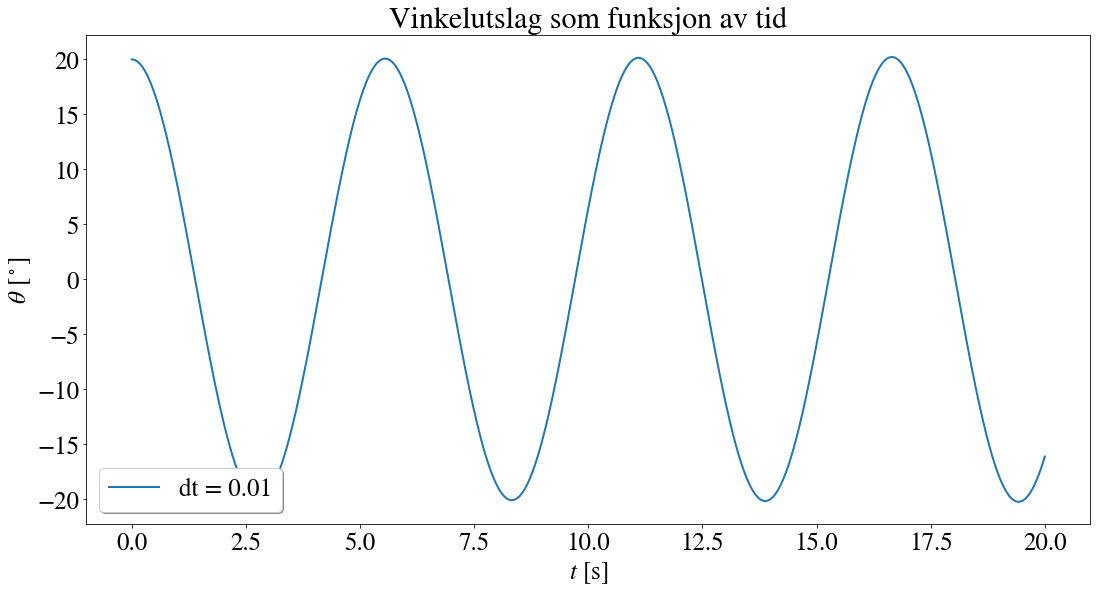

In [10]:
def test_euler():
    # f = lambda t, w: np.array([
    #     w[1],
    #     -(A_0 * sigma_0 * g * h)/calculate_I_c(0, 0) * np.sin( w[0] )
    #     ])
    
    # This function is equivalent
    def f(t, w):
        dw = np.array([
            w[1],
            -(A_0 * sigma_0 * g * h)/calculate_I_c(0, 0) * np.sin( w[0] )
        ])
        print("w_0 that works: ", w[0])
        print(type(w[0]))
        return dw

    # Define the inital condititons, time intervall, and step size
    theta_0 = np.array([np.radians(20)])
    omega_0 = np.array([0])
    w_0 = np.array([theta_0, omega_0]) # Combine all the initial conditions to the array w

    t_0 = 0
    t_end = 20

    h_step = 0.001  #The step size of our simulation


    # Calculate the angles and angle velocities in the given time intervall using the Euler method
    t_num, w_num = solve_ODE(f, t_0, t_end, w_0, h_step, euler_step)

    theta_num, omega_num = w_num[0:2]
    # print(f'theta:\n {theta_num}\n\nomega:\n{omega_num}')
    

    # Plot the angles vs time
    plt.plot(t_num, np.rad2deg(theta_num), label = "dt = 0.01")
    plt.title("Vinkelutslag som funksjon av tid")
    plt.xlabel('$t$ [s]')           
    plt.ylabel(r'$\theta$ [$^\circ$]')   
    # plt.ylim(-0.4,0.4)        
    plt.legend(loc=3, shadow = True)
    plt.show()

test_euler()

## Small angle approximation
...

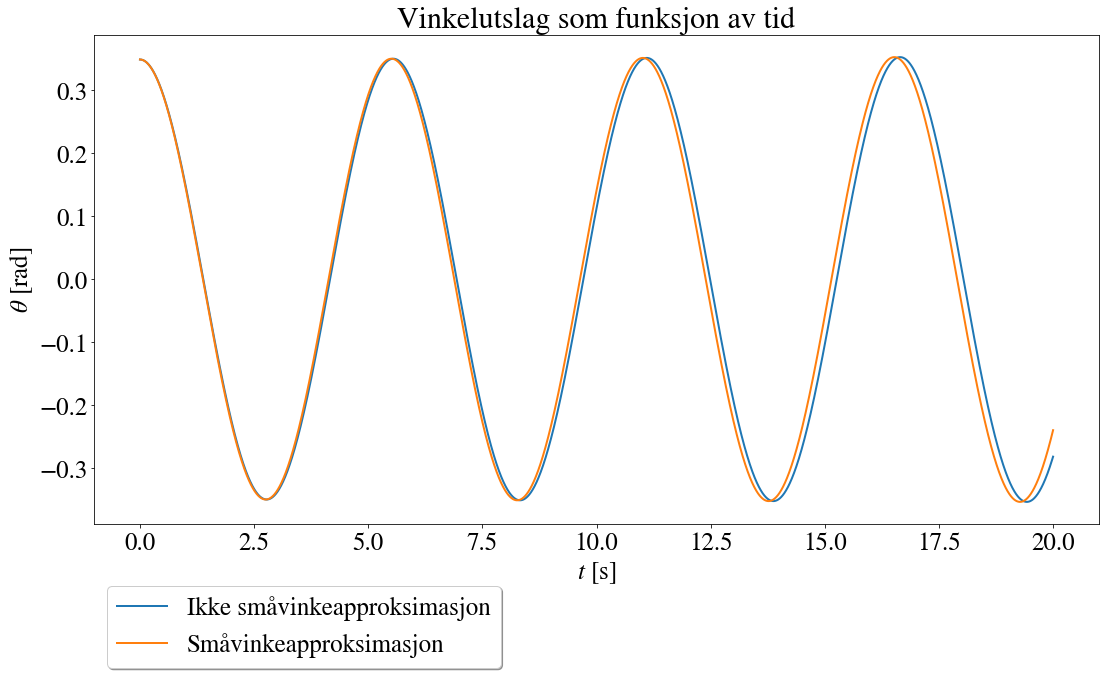

In [11]:
def angle_approx_comparison():
    # def f(t, w):
    #     const = (A_s*sigma * g * h)/calculate_I_c(0, 0)
    #     return np.array([w[1], -const*np.sin(w[0]),0,0,0,0,0,0])

    # def f_small_angle(t, w):
    #     const = (A_s*sigma * g * h)/calculate_I_c(0, 0)
    #     return np.array([w[1], -const*w[0],0,0,0,0,0,0])

    #######################################################################################
    #       Define the functions differential equations that we will be solving
    f = lambda t, w: np.array([
        w[1],
        -(A_s*sigma * g * h)/calculate_I_c(0, 0) * np.sin(w[0])
    ])
    f_small_angle = lambda t, w: np.array([
        w[1],
        -(A_s*sigma * g * h)/calculate_I_c(0, 0) * w[0]
    ])

    #######################################################################################
    #       Define the inital condititons, time intervall, and step size
    theta_0 = np.array([np.radians(20)])
    omega_0 = np.array([0])
    w_0 = np.array([theta_0, omega_0]) # Combine all the initial conditions to the array w

    t_0 = 0
    t_end = 20

    h_step = 0.001  #The step size of our simulation
    #######################################################################################
    #       Solve diff. eqn. by the given methods, and 
    t_num, w_num = solve_ODE(f, t_0, t_end, w_0, h_step, euler_step)
    t_num_small_angle_approx, w_num_small_angle_approx = solve_ODE(f_small_angle, t_0, t_end, w_0, h_step,euler_step)


    theta_num, omega_num = w_num[0:2]
    theta_num_small_angle_approx, omega_num_small_angle_approx = w_num_small_angle_approx[0:2]
    
    diff = theta_num_small_angle_approx - theta_num    


    plt.plot(t_num, theta_num, label = "Ikke småvinkeapproksimasjon")
    plt.plot(t_num_small_angle_approx, theta_num_small_angle_approx, label = "Småvinkeapproksimasjon")
    # plt.plot(t_num, diff, label = "Differanse")
    plt.title("Vinkelutslag som funksjon av tid")
    plt.xlabel('$t$ [s]')           
    plt.ylabel(r'$\theta$ [rad]')   
    # plt.ylim(-0.2,0.2)        
    plt.legend( 
        bbox_to_anchor=(0,-0.1),
        loc='upper left',
        shadow = True
        )
    plt.show()

angle_approx_comparison()

## 1.3 Runge Kutta metoden

Implementerer fjerde ordens Runge Kutta.


In [12]:
def rk4_step(f, t, w, h):
    '''
    Tar inn en vektor-funksjon på formen f(t, _w_) = _y'_ = _y_ + _g(x)_, med nåværende tid (t) og 
    tilstand (w), og regner ut ett Runge Kutta steg.
    Inn:
        f: s-array, som beskriver et system av førsteordens diff-ligninger.
        t: float, nåvernde tid
        w: s-array, som beskriver systemet
    Ut:
        t_new: neste tidssteg (t+h)
        w_new: systemet etter ett beregnet tidssteg    
    '''

    k_1 = f(t, w)
    k_2 = f(t + 0.5*h, w + h*k_1*0.5)
    k_3 = f(t + 0.5*h, w + h*k_2*0.5)
    k_4 = f(t + 1.0*h, w + h*k_3)

    w_new = w + h*(1/6) * (k_1 + 2*k_2 + 2*k_3 + k_4)
    t_new = t + h

    return t_new, w_new




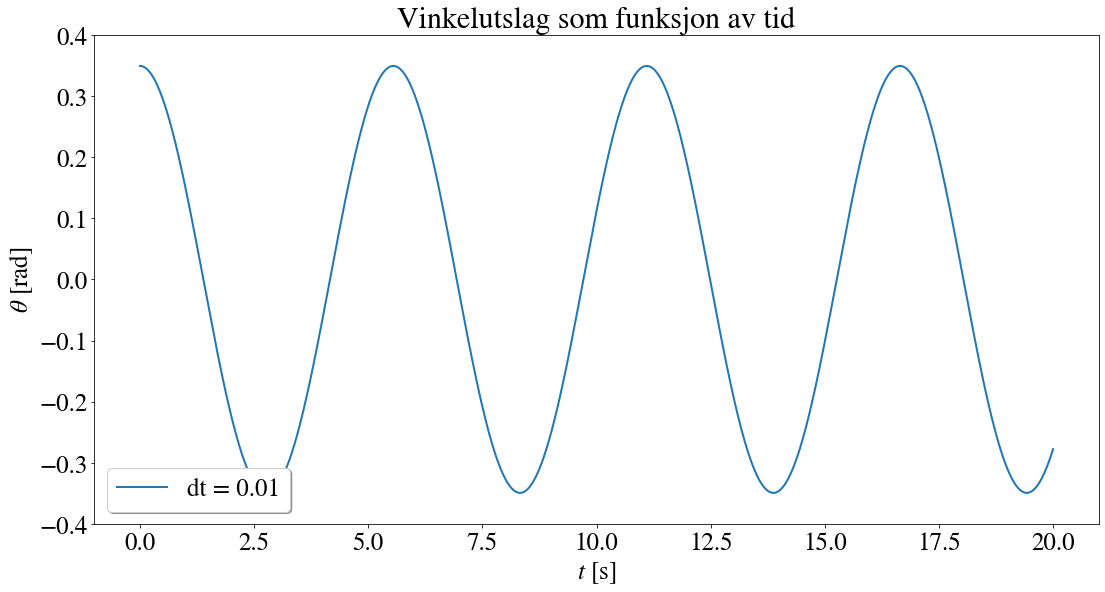

In [13]:
def test_runge_kutta():

    # def f(t, w):
    #     const = (A_s*sigma * g * h)/calculate_I_c(0, 0)
    #     return np.array([w[1], -const*np.sin(w[0]),0,0,0,0,0,0])
    
    #######################################################################################
    #       Define the functions differential equations that we will be solving
    f = lambda t, w: np.array([
        w[1],
        -(A_0 * sigma_0 * g * h)/calculate_I_c(0, 0) * np.sin( w[0] )
        ])


    #######################################################################################
    #       Define the inital condititons, time intervall, and step size
    theta_0 = np.array([np.radians(20)])
    omega_0 = np.array([0])
    w_0 = np.array([theta_0, omega_0]) # Combine all the initial conditions to the array w

    t_0 = 0
    t_end = 20

    h_step = 0.01  #The step size of our simulation
    #######################################################################################

    t_num_rk4, w_num_rk4 = solve_ODE(f, t_0, t_end, w_0, h_step, rk4_step)
    theta_num_rk4, omega_num_rk = w_num_rk4[0:2]


    plt.plot(t_num_rk4, theta_num_rk4, label = "dt = 0.01")
    plt.title("Vinkelutslag som funksjon av tid")
    plt.xlabel('$t$ [s]')           
    plt.ylabel(r'$\theta$ [rad]')   
    plt.ylim(-0.4,0.4)        
    plt.legend(loc=3, shadow = True)
    plt.show()
    

test_runge_kutta()

## 1h)
...


In [14]:
def anal_vs_num():
    #######################################################################################
    #       Define the functions differential equations that we will be solving
    def f_analytic(t):
        return 0.01*np.cos(np.sqrt((m_boat*g*h)/calculate_I_c(0, 0))*t)
    
    # To be used in numerical solutions
    f_small_angle = lambda t, w: np.array([
        w[1],
        -(A_0 * sigma_0 * g * h)/calculate_I_c(0, 0) * w[0]
        ])
    f_not_small_angle = lambda t, w: np.array([
        w[1],
        -(A_0 * sigma_0 * g * h)/calculate_I_c(0, 0) * np.sin( w[0] )
        ])
    
    # def f_small_angle(t, w):
    #     const = (A_s*sigma * g * h)/calculate_I_c(0, 0)
    #     return np.array([w[1], -const*w[0],0,0,0,0,0,0])
    # def f_not_small_angle(t, w):
    #     const = (A_s*sigma * g * h)/calculate_I_c(0, 0)
    #     return np.array([w[1], -const*  np.sin(w[0]),0,0,0,0,0,0])


    # theta_0 = np.radians(0.01)
    # omega_0 = 0
    # w_0 = np.array([theta_0, omega_0,0,0,0,0,0,0])

    # t_0 = 0
    # t_end = 20


    #######################################################################################
    #       Define the inital condititons, time intervall, the array of step sizes, 
    #       and the analytic value at t=20s
    theta_0 = np.array([0.01])
    omega_0 = np.array([0])
    w_0 = np.array([
        theta_0, 
        omega_0
        ]) # Combine all the initial conditions to the array w

    t_0 = 0
    t_end = 20

    h_steps = np.linspace(0.01, 0.06, 200)


    #######################################################################################
    #       Find the values of different methods (including analytic) at t=20s
    #       using different step sizes
    f_analytic_t_20 = f_analytic(20) # Analytic value at t=20s

    theta_t20_arr_euler = np.array([])
    theta_t20_arr_rk4 = np.array([])

    # Iterate through all the desired step sizes, and store them
    for h_step in h_steps:
        theta_euler    =   solve_ODE(f_small_angle, t_0, t_end, w_0, h_step, euler_step)[1][0] #[1]: w, [0]: theta
        theta_rk4      =   solve_ODE(f_small_angle, t_0, t_end, w_0, h_step, rk4_step)[1][0]

        # Store the angle at t=20s (the last angle)
        theta_t20_arr_euler =   np.append(theta_t20_arr_euler, theta_euler[-1])
        theta_t20_arr_rk4   =   np.append(theta_t20_arr_rk4 , theta_rk4[-1])


    difference_euler    = np.abs(theta_t20_arr_euler   -   f_analytic_t_20)
    difference_rk4      = np.abs(theta_t20_arr_rk4     -   f_analytic_t_20)
    # difference_rk4 = np.abs(difference_rk4)
    
    #######################################################################################
    #       Save the data to a file
    np.savez(
        'simulation_data/difference_at_t20',
        h_steps = h_steps,
        difference_euler = difference_euler,
        difference_rk4 = difference_rk4
        
        )
# anal_vs_num()

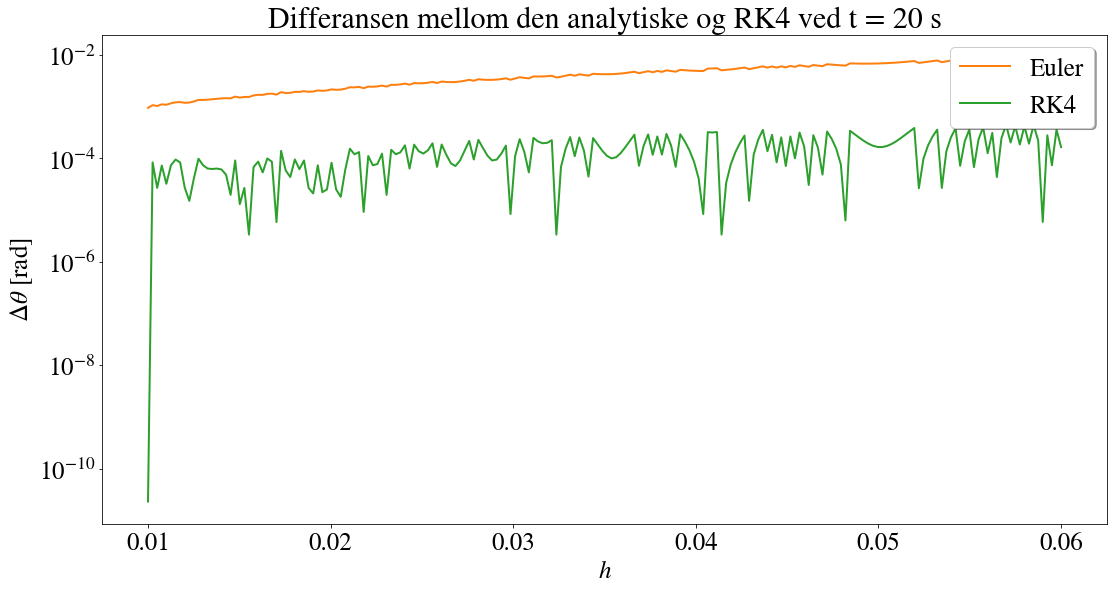

In [15]:

#######################################################################################
#       Plot the differences
def plot_difference():
    
    diff_data = np.load('simulation_data/difference_at_t20.npz')
    h_steps, difference_euler, difference_rk4 = diff_data['h_steps'], diff_data['difference_euler'], diff_data['difference_rk4']

    plt.yscale("log")
    plt.plot(h_steps, np.zeros(len(h_steps)),linestyle='--') # Stiplet linje i 0
    plt.plot(h_steps, difference_euler, label = "Euler")
    plt.plot(h_steps, difference_rk4, label = "RK4")

    plt.title("Differansen mellom den analytiske og RK4 ved t = 20 s")
    plt.xlabel('$h$')           
    plt.ylabel(r'$\Delta\theta$ [rad]')   
    #plt.ylim(-0.2,0.2)        
    plt.legend(loc=1, shadow = True)
    plt.show()


    # plt.yscale("log")
    # plt.plot(h_steps, np.zeros(len(h_steps)),linestyle='--') # Stiplet linje i 0
    # plt.plot(h_steps, difference_euler, label = "Euler")
    # plt.plot(h_steps, difference_rk4, label = "RK4")

    # plt.title("Differansen mellom den analytiske og RK4 ved t = 20 s")
    # plt.xlabel('$h$')           
    # plt.ylabel(r'$\Delta\theta$ [rad]')

    # plt.legend(loc=2, shadow = True)
    # plt.show()

plot_difference()

## 2b

beta =  2.309881463499782
2b: y val:  [-0.2044043]
Delta y  [0.]
theta:  [0.34906585]
2b: y val:  [-0.2044043]
Delta y  [0.]
theta:  [0.34906585]
2b: y val:  [-0.20438959]
Delta y  [1.47105546e-05]
theta:  [0.34905405]
2b: y val:  [-0.20437488]
Delta y  [2.94211092e-05]
theta:  [0.34904226]
2b: y val:  [-0.20437488]
Delta y  [2.94198823e-05]
theta:  [0.34904226]
2b: y val:  [-0.20434546]
Delta y  [5.88385377e-05]
theta:  [0.34901866]
2b: y val:  [-0.20433075]
Delta y  [7.35454118e-05]
theta:  [0.34900687]
2b: y val:  [-0.20428664]
Delta y  [0.00011766]
theta:  [0.34897148]
2b: y val:  [-0.20428663]
Delta y  [0.00011766]
theta:  [0.34897148]
2b: y val:  [-0.20422781]
Delta y  [0.00017649]
theta:  [0.3489243]
2b: y val:  [-0.20421312]
Delta y  [0.00019118]
theta:  [0.3489125]
2b: y val:  [-0.20413961]
Delta y  [0.00026469]
theta:  [0.34885353]
2b: y val:  [-0.20413961]
Delta y  [0.00026469]
theta:  [0.34885353]
2b: y val:  [-0.20405141]
Delta y  [0.00035289]
theta:  [0.34878277]
2b: y va

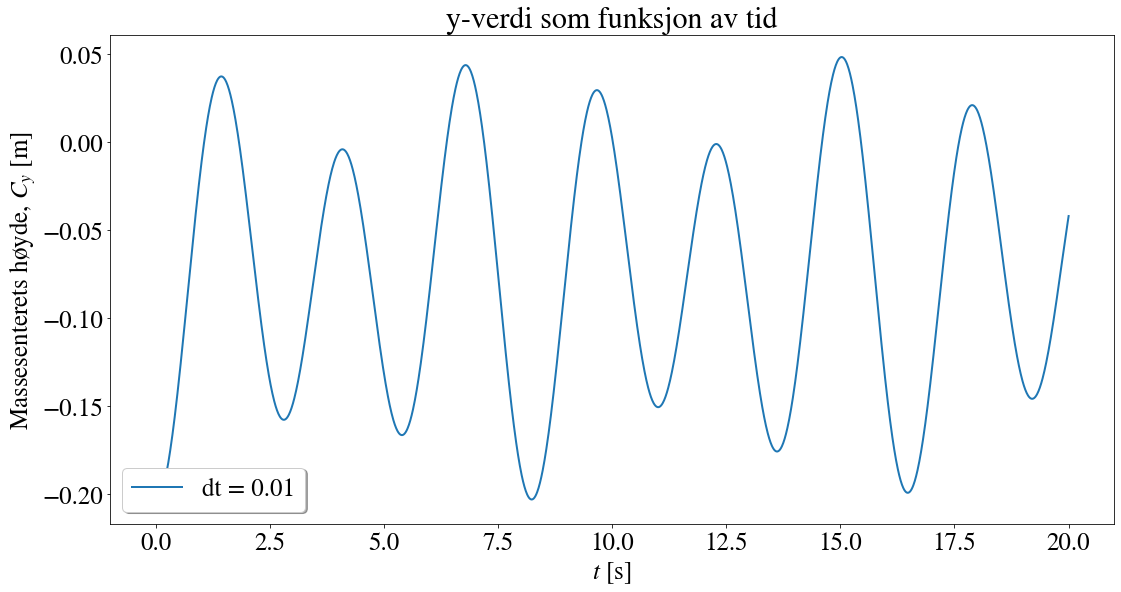

In [16]:
def cm_plot():
    beta = calculate_beta(np.pi*sigma/sigma_0, 5) # Guess 5 for initial beta
    print("beta = ",beta)
    
    def f(t, w):  
        '''
        Funksjon som brukes til å regne ut endringen til systemet.
        Inn:
            t: float, tid
            w: s-array, beskriver diverse av systemets fysiske egenskaper
        Ut:
            dw: endringen i w i det neste tidssteget
        
        '''
        print("2b: y val: ", w[3])
        delta_y_c_current = w[3] - y_C_0(beta) 
        print("Delta y ", delta_y_c_current)
        print("theta: ", w[0])

        gamma_current = 2*np.arccos(np.cos(beta/2) - (4/(3*np.pi))*(1-np.cos(w[0])) + delta_y_c_current/R)

        A = water_area(gamma_current)
       
        d_theta = w[1]
        d_omega = -((F_B(A) * h)/calculate_I_c(0, 0))*np.sin(w[0])
        d_x     = w[4]
        d_y     = w[5]
        d_v_x   = np.array([0])
        d_v_y   = (F_G(m_boat) + F_B(A))/m_boat



        dw = np.array([
            d_theta,
            d_omega,
            d_x,
            d_y,   
            d_v_x,  
            d_v_y
             
        ])
        
        
        return dw

    theta_0 = np.array([np.radians(20)])
    omega_0 = np.array([0])
    x_C_0 = np.array([0])
    initial_y_C = np.array([y_C_0(beta)])
    v_x_0 = np.array([0])
    v_y_0 = np.array([0])



    w_0 = np.array([
        theta_0, 
        omega_0, 
        x_C_0, 
        initial_y_C, 
        v_x_0, 
        v_y_0
        ])



    t_0 = 0
    t_end = 20

    h_step = 0.01

    t_num_rk4, w_num_rk4 = solve_ODE(f, t_0, t_end, w_0, h_step, rk4_step)
    np.savez('simulation_data/rk4_water_move',t_num_rk4=t_num_rk4,w_num_rk4=w_num_rk4)

    y_num_rk4 = w_num_rk4[3]
    
    plt.plot(t_num_rk4, y_num_rk4, label = "dt = 0.01")
    plt.title("y-verdi som funksjon av tid")
    plt.xlabel('$t$ [s]')           
    plt.ylabel(r'Massesenterets høyde, $C_y$ [m]')   
    # plt.ylim(-0.25,0.25)        
    plt.legend(loc=3, shadow = True)
    plt.show()

cm_plot()

## Oppg 2c



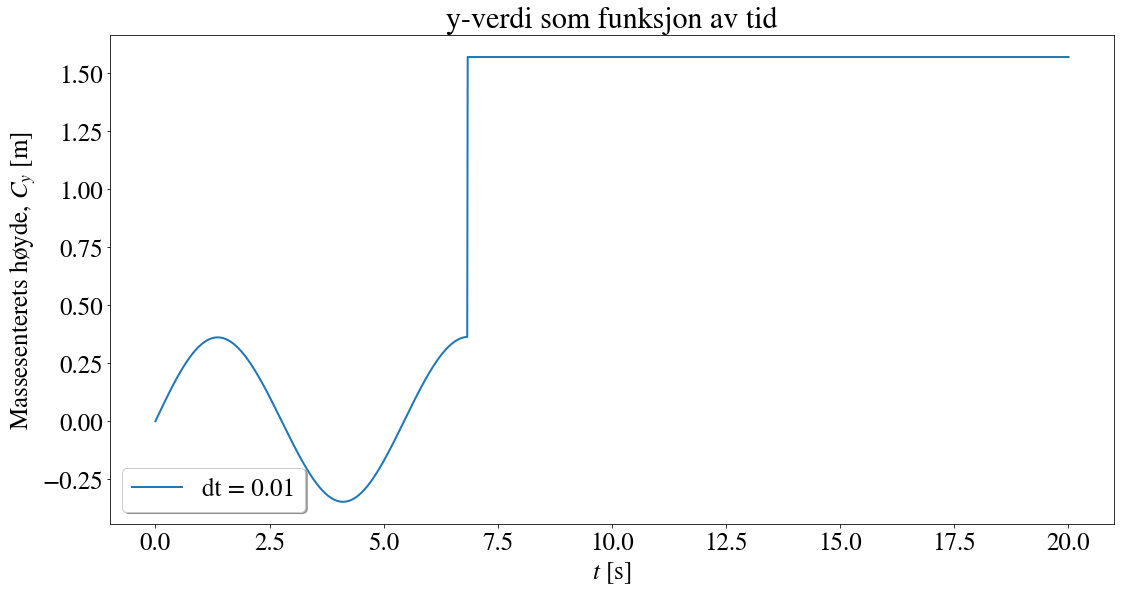

In [27]:
def check_capsizing(w_num):
    '''
    Checks if the boat is capsizing. 
    Input:
    w_num: array with all the physical properties of the boat
    output:
    w_num: Same array, but now updated values if the boat has capsized.
    
    '''
    beta = calculate_beta(np.pi*sigma/sigma_0, 5) # Guess 5 for initial beta

    theta_arr = w_num[0]
    y_arr = w_num[3]
    for i in range(len(theta_arr)-1):
        theta_n = theta_arr[i]
        delta_y_n= y_arr[i+1]-y_arr[i]
        delta_y_c_n = y_C(beta,delta_y_n)
        if theta_n > 0.5*(np.pi-gamma(beta,theta_n,delta_y_c_n,)): #Sjekk om båten kantrer
        
            
            theta_arr[i+1] = np.pi/2 * np.sign(theta_arr[i])
           
            for j in range(1,(len(w_num))):
                w_num[j]=0
    return w_num
    
def cm_plot_c():
    beta = calculate_beta(np.pi*sigma/sigma_0, 5) # Guess 5 for initial beta
    
    def f(t, w):  
        '''
        Funksjon som brukes til å regne ut endringen til systemet.
        Inn:
            t: float, tid
            w: s-array, beskriver diverse av systemets fysiske egenskaper
        Ut:
            dw: endringen i w i det neste tidssteget
        
        '''
    
        delta_y_c_current = w[3] - y_C_0(beta)  
        # print("cm_plot_c w3",w[3])
        # print("gamma innmat: ", np.cos(beta/2) - (4/(3*np.pi))*(1-np.cos(w[0])) + delta_y_c_current/R)
        gamma_current = 2*np.arccos(np.cos(beta/2) - (4/(3*np.pi))*(1-np.cos(w[0])) + delta_y_c_current/R)

        A = water_area(gamma_current)
       
        d_theta = w[1]
        d_omega = -((F_B(A) * h)/calculate_I_c(0, 0))*np.sin(w[0])
        d_x     = w[4]
        d_y     = w[5]
        d_v_x   = np.array([0])
        d_v_y   = (F_G(m_boat) + F_B(A))/m_boat


        dw = np.array([
            d_theta,
            d_omega,
            d_x,
            d_y,   
            d_v_x,  
            d_v_y 
        ])
        
        
        return dw

    theta_0 = np.array([np.radians(0)])
    omega_0 = np.array([np.radians(23.8)])
    x_C_0 = np.array([0])
    initial_y_C = np.array([y_C_0(beta)])
    v_x_0 = np.array([0])
    v_y_0 = np.array([0])

    w_0 = np.array([
        theta_0, 
        omega_0, 
        x_C_0, 
        initial_y_C, 
        v_x_0, 
        v_y_0
    ])

    t_0 = 0
    t_end = 20

    h_step = 0.01

    t_num_rk4, w_num_rk4 = solve_ODE(f, t_0, t_end, w_0, h_step, rk4_step)
    # print(w_num_rk4[0])
    w_num_rk4 = check_capsizing(w_num_rk4)
    theta_arr = w_num_rk4[0]
    # print(theta_arr)

    np.savez('simulation_data/rk4_water_move',t_num_rk4=t_num_rk4,w_num_rk4=w_num_rk4)

    y_num_rk4 = w_num_rk4[3]
    plt.plot(t_num_rk4, theta_arr, label = "dt = 0.01")
    plt.title("y-verdi som funksjon av tid")
    plt.xlabel('$t$ [s]')           
    plt.ylabel(r'Massesenterets høyde, $C_y$ [m]')   
    # plt.ylim(-0.25,0.25)        
    plt.legend(loc=3, shadow = True)
    plt.show()

cm_plot_c()


In [18]:
# def cm_plot_capsizing():
#     beta = calculate_beta(np.pi*sigma/sigma_0, 5) # Guess 5 for initial beta
#     print(beta)
#     print(np.degrees(beta))
#     def f(t, w):  
#         '''
#         Funksjon som brukes til å regne ut de nye verdiene til w-arrayet.
#         Inn:
#             t: float, tid
#             w: s-array, beskriver diverse av systemets fysiske egenskaper
#         Ut:
#             w-arrayet med oppdaterte verdier
        
#         '''
    
#         delta_y_c_current = w[3] - y_C_0(beta)  
#         print(w[3])

#         #print("arccos innmat: ",np.cos(beta/2) - (4/(3*np.pi))*(1-np.cos(w[0])) + delta_y_c_current/R)
#         gamma_current = 2*np.arccos(np.cos(beta/2) - (4/(3*np.pi))*(1-np.cos(w[0])) + delta_y_c_current/R)

#         A = water_area(gamma_current)
#         return np.array([w[1], -((F_B(A) * h)/calculate_I_c(0, 0))*np.sin(w[0]), w[4], w[5], np.array([0]), (F_G(m_boat) + F_B(A))/m_boat])


#     theta_0 = np.array([np.radians(0)])
#     omega_0 = np.array([30.8])
#     x_C_0 = np.array([0])
#     initial_y_C = np.array([y_C_0(beta)])
#     v_x_0 = np.array([0])
#     v_y_0 = np.array([0])



#     w_0 = np.array([theta_0, omega_0, x_C_0, initial_y_C, v_x_0, v_y_0])

#     t_0 = 0
#     t_end = 20

#     h_step = 0.01

#     t_num_rk4, w_num_rk4 = solve_ODE(f, t_0, t_end, w_0, h_step, rk4_step)
#     w_num_rk4 = check_capsizing(w_num_rk4)
#     theta_arr = w_num_rk4[0]
#     np.savez('simulation_data/rk4_water_move',t_num_rk4=t_num_rk4,w_num_rk4=w_num_rk4)

#     plt.plot(t_num_rk4, theta_arr, label = "dt = 0.01")
#     plt.title("Vinkelutslag som funksjon av tid")
#     plt.xlabel('$t$ [s]')           
#     plt.ylabel(r'Massesenterets høyde, $C_y$ [m]')   
#     # plt.ylim(-0.25,0.25)        
#     plt.legend(loc=3, shadow = True)
#     plt.show()

# cm_plot_capsizing()

## Oppg 2d

In [19]:
def boat_with_load():
        
    def f(t, w):  
        '''
        Funksjon som brukes til å regne ut de nye verdiene til w-arrayet.
        Inn:
            t: float, tid
            w: s-array, beskriver diverse av systemets fysiske egenskaper
        Ut:
            w-arrayet med oppdaterte verdier
        
        '''
        m_load = 0.2*m_boat #Gjør om til array senere, evt som input til funksjonen
        m_tot = m_boat + m_load
        
        beta = calculate_beta(np.pi*sigma/sigma_0 + 2*m_load/(sigma_0 * R**2),5) #Ikke lenger samme som før
        print("beta = ", np.degrees(beta))

        A = (np.pi * R**2 *sigma + 2*m_load)/(2*sigma_0) #eller A_0?
        
        delta_y_c_current = w[3] - y_C_0(beta) 
        I_c = calculate_I_c(m_tot,)
        gamma_current = 2*np.arccos(np.cos(beta/2) - (4/(3*np.pi))*(1-np.cos(w[0])) + delta_y_c_current/R)

        # A = water_area(gamma_current) #gammel
        return np.array([w[1],    -((F_B(A) * h)/I_c)*np.sin(w[0] ), w[4], w[5], 0, (F_G(m_tot) + F_B(A))/m_tot,0,0])


    def plot_with_load():
        theta_0 = np.radians(0)
        omega_0 = np.radians(23.8) #Rundt her et sted, men sjekk med newtons metode på ligningen hvis det er mulig
        x_C_0 = 0
        v_x_0 = 0
        v_y_0 = 0

        w_0 = np.array([theta_0, omega_0, x_C_0, y_C_0, v_x_0, v_y_0,0,0])

        t_0 = 0
        t_end = 20

        h_step = 0.01

        t_num_rk4, w_num_rk4 = solve_ODE(f, t_0, t_end, w_0, h_step, rk4_step)
        w_num_rk4 = check_capsizing(w_num_rk4)
        theta_arr = w_num_rk4[:,0]
        np.savez('simulation_data/rk4_water_move',t_num_rk4=t_num_rk4,w_num_rk4=w_num_rk4)

        plt.plot(t_num_rk4, theta_arr, label = "dt = 0.01")
        plt.title("Vinkelutslag som funksjon av tid")
        plt.xlabel('$t$ [s]')           
        plt.ylabel(r'Massesenterets høyde, $C_y$ [m]')   
        # plt.ylim(-0.25,0.25)        
        plt.legend(loc=3, shadow = True)
        plt.show()
    plot_with_load()
    
#boat_with_load()

# X.0 Conclusion

Lorem Ipsum...